<a href="https://colab.research.google.com/github/x18134301/x18134301_TusharDalvi/blob/master/Augmentation_pneumonia_Classification_using_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import cv2
import numpy as np
import random
#!pip install Image
#import Image
from PIL import Image
from PIL import ImageOps
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)\
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

Setting Seed and checking directory

In [8]:
np.random.seed(1000)
#new layers end here
print(os.listdir("/content/gdrive/My Drive/chest_xray"))

['val', 'test', 'train', '.DS_Store']


lets check the Data

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

Need to explore data

In [0]:
# Define path to the data directory
data_dir = Path('/content/gdrive/My Drive/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

#                                                Trainning Data Count

In [0]:
#PNEUMONIA: This directory contains those samples that are the pneumonia cases.
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,/content/gdrive/My Drive/chest_xray/train/NORM...,0
1,/content/gdrive/My Drive/chest_xray/train/PNEU...,1
2,/content/gdrive/My Drive/chest_xray/train/NORM...,0
3,/content/gdrive/My Drive/chest_xray/train/PNEU...,1
4,/content/gdrive/My Drive/chest_xray/train/NORM...,0


#Trainning Data Count Graph

1    3875
0    1341
Name: label, dtype: int64


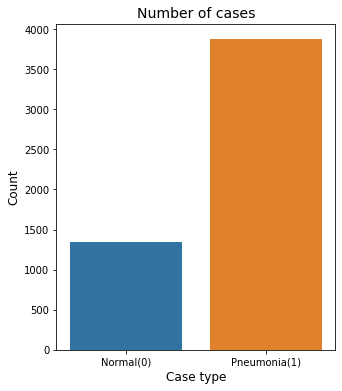

In [0]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(5,6))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

#Testing Data Count

In [0]:
#PNEUMONIA: This directory contains those samples that are the pneumonia cases.
# Get the path to the normal and pneumonia sub-directories
normal_test_cases_dir = test_dir / 'NORMAL'
pneumonia_test_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_cases = normal_test_cases_dir.glob('*.jpeg')
test_pneumonia_cases = pneumonia_test_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,/content/gdrive/My Drive/chest_xray/test/NORMA...,0
1,/content/gdrive/My Drive/chest_xray/test/NORMA...,0
2,/content/gdrive/My Drive/chest_xray/test/PNEUM...,1
3,/content/gdrive/My Drive/chest_xray/test/PNEUM...,1
4,/content/gdrive/My Drive/chest_xray/test/PNEUM...,1


#Testing Data Count Graph

1    390
0    234
Name: label, dtype: int64


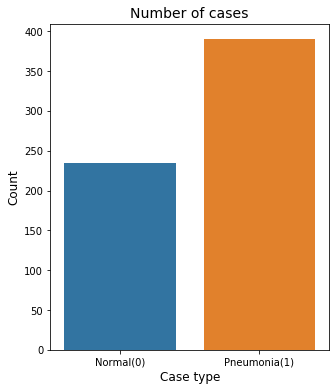

In [0]:
# Get the counts for each class
test_cases_count = test_data['label'].value_counts()
print(test_cases_count)

# Plot the results 
plt.figure(figsize=(5,6))
sns.barplot(x=test_cases_count.index, y= test_cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

# Augmentation

In [11]:
# Load and augment training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/My Drive/chest_xray/train',
    batch_size=16,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical'
)

Found 5216 images belonging to 2 classes.


In [12]:
# Load validation and test data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    '/content/gdrive/My Drive/chest_xray/val',
    batch_size=16,
    target_size=(224, 224),
    class_mode='categorical'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(
    '/content/gdrive/My Drive/chest_xray/test',
    batch_size=16,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
from keras.applications.vgg16 import VGG16
VGGmodel = VGG16()

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [0]:
model = Sequential()
model.add(VGGmodel)
model.add(Dense(2, activation='softmax'))

In [34]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1000)              138357544 
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2002      
Total params: 138,359,546
Trainable params: 138,359,546
Non-trainable params: 0
_________________________________________________________________


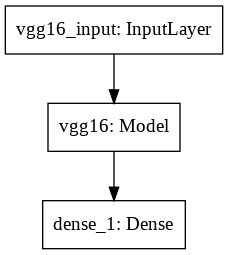

In [35]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='VGG.png')

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
Epoch = model.fit_generator(
    train_generator,
    epochs=1,
    verbose=1,
    validation_data=val_generator,
)

Epoch 1/1
 71/326 [=====>........................] - ETA: 2:32:35 - loss: 0.6432 - acc: 0.7518